## Assignment 2: CNNs for image classification

Subin Pulliyil Santhosh - a1917668

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import copy
import matplotlib.pyplot as plt
import numpy as np

In [121]:
# function to define CIFAR10 data transformations with and without data augmntation
def get_cifar_transforms(data_augmentation=False):
    if data_augmentation:
        transform_train = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15), 
            transforms.RandomCrop(224, padding = 4),
            transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
    else:
        transform_train = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    return transform_train, transform_test


# load CIFAR10 dataset with train validation test split
transform_train, transform_test = get_cifar_transforms(data_augmentation = True)

train_dataset = datasets.CIFAR10(root='./data', train = True, download = True, transform = transform_train)
test_dataset = datasets.CIFAR10(root='./data', train = False, download = True, transform = transform_test)

#split the training dataset into train and validation sets
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(0.8 * num_train)
train_idx, valid_idx = indices[:split], indices[split:]

device = "cpu"

# samplers to create train and validation loaders
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

# data loaders for training, validation and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, sampler = train_sampler, num_workers = 2)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, sampler = valid_sampler, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False, num_workers = 2)


Files already downloaded and verified
Files already downloaded and verified


In [122]:
# models to train from scratch without pretrained weights
models_dict = {
    'Resnet18': models.resnet18(weights = None),# ResNet18 model
    'Alexnet': models.alexnet(weights = None),# AlexNet model
    'MobilenetV2': models.mobilenet_v2(weights = None)# MobileNetV2 model
}

# modifying the final layers of each model to output 10 classes for CIFAR10
for model_name, model in models_dict.items():
    if 'Resnet' in model_name:
        model.fc = nn.Linear(model.fc.in_features, 10)# ResNet18 adjustment
    elif 'Alexnet' in model_name or 'Mobilenet' in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)# AlexNet and MobileNetV2 adjustment
    model = model.to("cpu")


In [123]:
# function to train and validate model with given hyperparameters
def train_model(model, criterion, optimiser, scheduler, num_epochs = 10, patience = 3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # track the best validation accuracy
    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []

    # earlystopping
    early_stop_counter = 0
    early_stop_threshold = patience  #stop if no improvement

    for epoch in range(num_epochs):
        print('\n')
        print('----------')
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('----------')

        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimiser.zero_grad()

                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Training':
                        loss.backward()
                        optimiser.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'Training':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {epoch_acc:.4f}')

            # save best weights based on validation accuracy
            if phase == 'Validation':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0 
                else:
                    early_stop_counter += 1  #increase if no improvement

        # Early stopping check
        if early_stop_counter >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch + 1}. no improvement in validation accuracy for {patience} epochs.")
            break

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [124]:
# testing function to evaluate the final model on the test set
def test_model(model):
    model.eval()#setting model to evaluation mode
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(test_loader.dataset)
    print("\n")
    print(f'Test Accuracy: {test_acc:.4f}')
    print("\n")
    return test_acc

In [133]:
#experiment with different hyperparameters for each model
results = {}
for model_name, model in models_dict.items():
    print(f'\nTraining {model_name} with hyperparameter tuning on CIFAR10 : \n')
    
    #define ranges for different hyperparameters
    learning_rates = [0.01, 0.001]
    optimisers = [optim.SGD, optim.Adam]
    data_augmentations = [True, False]

    for lr in learning_rates:
        for opt in optimizers:
            for data_aug in data_augmentations:
                print(f"\n Model: {model_name}, Learning Rate = {lr}, Optimizer = {opt.__name__}, Data Augmentation = {data_aug}")
                
                #reinitialise the model to ensure it starts fresh
                model = models_dict[model_name]
                model = model.to("cpu")
                
                #set transforms based on data_augmentation flag
                transform_train, transform_test = get_cifar_transforms(data_augmentation = data_aug)
                train_dataset.transform = transform_train
                test_dataset.transform = transform_test
                
                #reload data loaders with chosen augmentation
                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, sampler = train_sampler, num_workers = 2)
                valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, sampler = valid_sampler, num_workers = 2)

                #initialise optimiser and scheduler
                criterion = nn.CrossEntropyLoss()
                optimiser_instance = opt(model.parameters(), lr = lr)
                scheduler = lr_scheduler.StepLR(optimiser_instance, step_size = 7, gamma = 0.1)

                #train and validate the model
                trained_model, train_loss, val_loss, train_acc, val_acc = train_model(
                    model, criterion, optimiser_instance, scheduler, num_epochs = 10
                )

                #test the best model on the test set and store results
                test_acc = test_model(trained_model)
                results[f"{model_name}_lr{lr}_{opt.__name__}_data_aug{data_aug}"] = {
                    'Training_loss': train_loss,
                    'Validation_Loss': val_loss,
                    'Training_Accuracy': train_acc,
                    'Validation_Accuracy': val_acc,
                    'Test_Accuracy': test_acc
                }


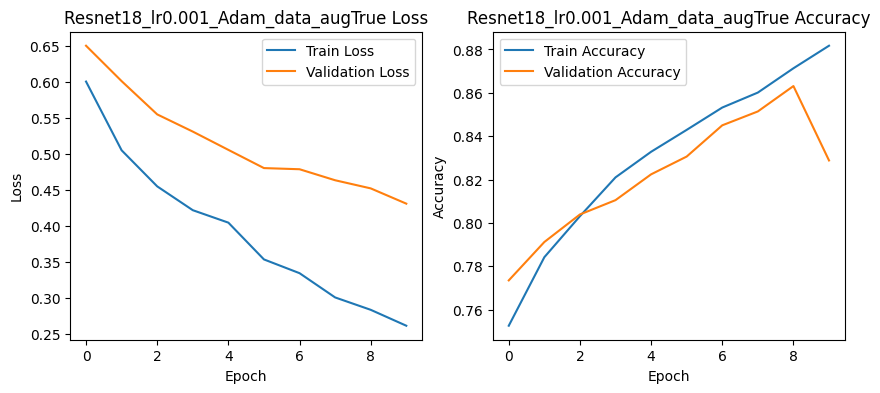

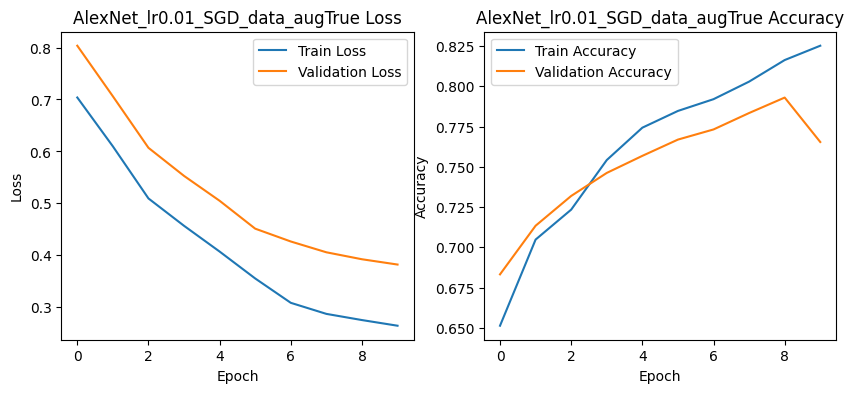

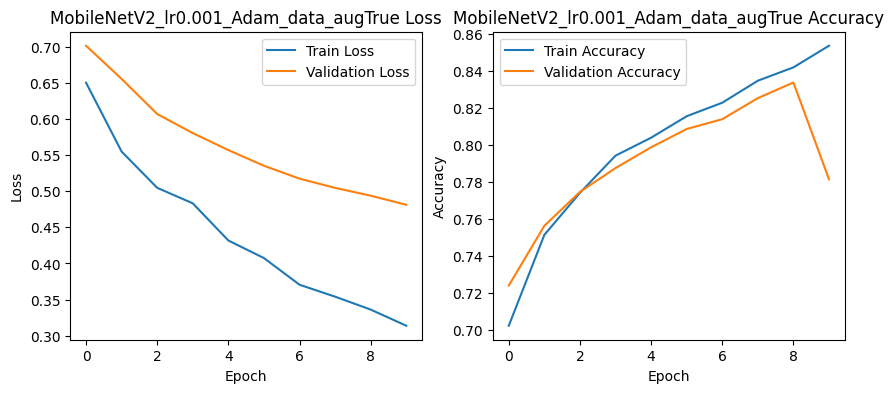

In [128]:
def plot_results(results):
     for config, metrics in results.items():
        plt.figure(figsize=(10, 4))

        # plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(metrics['Training_loss'], label = 'Train Loss')
        plt.plot(metrics['Validation_Loss'], label = 'Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{config} Loss')
        plt.legend()

        # plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(metrics['Training_Accuracy'], label = 'Train Accuracy')
        plt.plot(metrics['Validation_Accuracy'], label = 'Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'{config} Accuracy')
        plt.legend()
        plt.show()

#display plots of the results
plot_results(results)


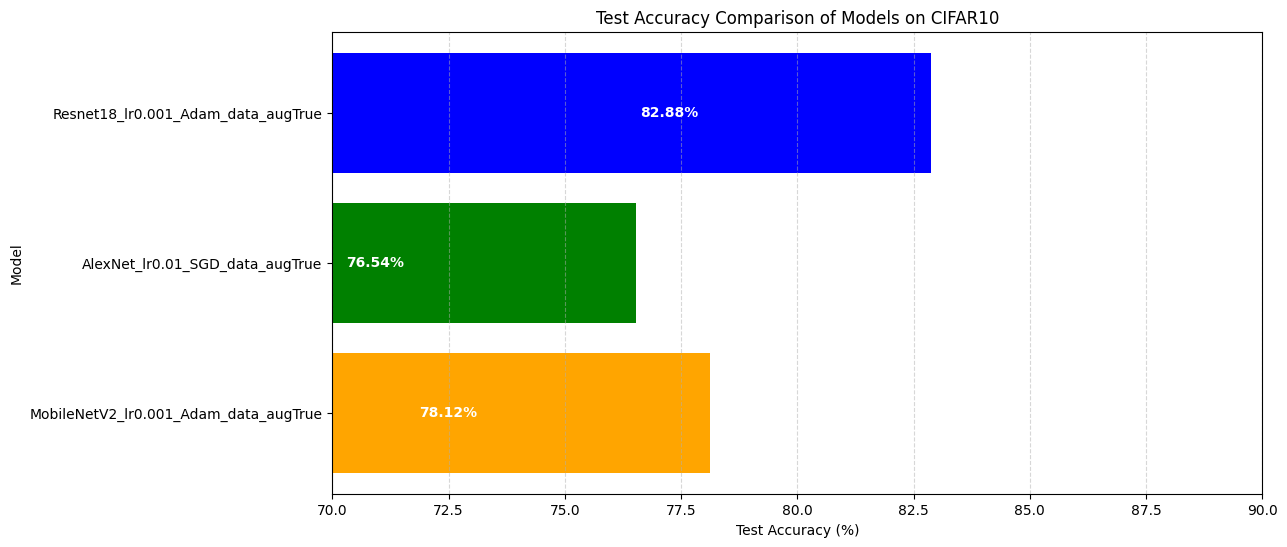

In [129]:
#model names and test accuracies
model_names = list(results.keys())
test_accuracies = [result["Test_Accuracy"] * 100 for result in results.values()] #percentage

#making a horizontal barplot
plt.figure(figsize=(12, 6))
bars = plt.barh(model_names, test_accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Test Accuracy (%)')
plt.ylabel('Model')
plt.title('Test Accuracy Comparison of Models on CIFAR10')

#labels
for bar, accuracy in zip(bars, test_accuracies):
    plt.text(
        bar.get_width() - 5, bar.get_y() + bar.get_height() / 2,
        f'{accuracy:.2f}%', ha = 'right', va = 'center', color = 'white', fontweight = 'bold'
    )

plt.grid(axis = 'x', linestyle = '--', alpha = 0.5)
plt.xlim(70, 90) 
plt.gca().invert_yaxis()

plt.show()
